In [341]:
import numpy as np
import pytreenet as ptn
from copy import deepcopy
import matplotlib.pyplot as plt

In [342]:
d = 2

shapes = {
    (0, 0): (3, 5, d),
    (0, 1): (3, d),
    (1, 0): (5, 4, d),
    (1, 1): (4, d)}

sites = {
    (i, j): ptn.random_tensor_node(shapes[(i, j)], 
            identifier=f"Site({i},{j})") 
            for i in range(2) for j in range(2)
}

ttn = ptn.TreeTensorNetworkState()

ttn.add_root(sites[(0, 0)][0], sites[(0, 0)][1])

connections = [
    ((0, 0), (0, 1), 0, 0),
    ((0, 0), (1, 0), 1, 0),
    ((1, 0), (1, 1), 1, 0)]

for (parent, child, parent_leg, child_leg) in connections:
    parent_id = f"Site({parent[0]},{parent[1]})"
    child_id = f"Site({child[0]},{child[1]})"
    ttn.add_child_to_parent(sites[child][0], sites[child][1], child_leg, parent_id, parent_leg)


def product_state(ttn, bond_dim=2):
    zero_state = deepcopy(ttn)
    zero = np.asarray([1/np.sqrt(2), 1/np.sqrt(2)])
    for node_id in zero_state.nodes.keys():
        n = zero_state.tensors[node_id].ndim - 1
        tensor = zero.reshape((1,) * n + (2,))
        T = np.pad(tensor, n*((0, bond_dim),) + ((0, 0),))
        zero_state.tensors[node_id] = T
        zero_state.nodes[node_id].link_tensor(T)  
    return zero_state

ttn = product_state(ttn , bond_dim= 4)


In [343]:
def BoseHubbard_ham(t, U, m, Lx, Ly , d):
    creation_op, annihilation_op, number_op = ptn.bosonic_operators(dimension=d)
    
    conversion_dict = {
        "b^dagger": creation_op,
        "b": annihilation_op,
        "n": number_op,
        f"I{d}": np.eye(d)
    }
    
    conversion_dict.update({
        "-t * b^dagger": -t * creation_op,
        "-t * b": -t * annihilation_op,
        "U * n * (n - 1)": U * number_op @ (number_op - np.eye(d)),
        "m*n": - m * number_op,
    })
    
    terms = []
    
    # Hopping terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            
            # Horizontal connections
            if x < Lx - 1:
                right_neighbor = f"Site({x+1},{y})"
                terms.append(ptn.TensorProduct({current_site: "-t * b^dagger", right_neighbor: "b"}))
                terms.append(ptn.TensorProduct({current_site: "-t * b", right_neighbor: "b^dagger"}))
            
            # Vertical connections
            if y < Ly - 1:
                up_neighbor = f"Site({x},{y+1})"
                terms.append(ptn.TensorProduct({current_site: "-t * b^dagger", up_neighbor: "b"}))
                terms.append(ptn.TensorProduct({current_site: "-t * b", up_neighbor: "b^dagger"}))
    
    # On-site interaction terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "U * n * (n - 1)"}))
            terms.append(ptn.TensorProduct({current_site: "m*n"}))
    
    return ptn.Hamiltonian(terms, conversion_dict)

def Number_op_total(Lx, Ly, dim=2):
    number_op = ptn.bosonic_operators(dim)[2]
    conversion_dict = {"n": number_op , f"I{dim}": np.eye(dim)}

    terms = []
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "n"}))
    return ptn.Hamiltonian(terms, conversion_dict) 
        
def Correlation_function(node_id1, node_id2, dim=2):
    creation_op, annihilation_op, number_op = ptn.bosonic_operators(dim)
    conversion_dict = {
        "b^dagger": creation_op,
        "b": annihilation_op,
        f"I{dim}": np.eye(dim)
    }
    
    terms = []
    terms.append(ptn.TensorProduct({node_id1: "b^dagger", node_id2: "b"}))
    return ptn.Hamiltonian(terms, conversion_dict)

def Random_op(Lx, Ly, dim , seed = 0):
    np.random.seed(seed)
    possible_operators = [ptn.crandn((dim,dim)) for _ in range(len(ttn.nodes.keys()))] 
    conversion_dict = {f"I{dim}": np.eye(dim)}
    for i, node_id in enumerate(ttn.nodes.keys()):
        conversion_dict[node_id] = possible_operators[i]    

    terms = [ptn.TensorProduct({f"Site({x},{y})": f"Site({x},{y})" 
                                for x in range(Lx) for y in range(Ly)})]
    return ptn.Hamiltonian(terms, conversion_dict)   


In [344]:
t = 3
u = 2
m = 1
Lx = 2
Ly = 2

H1 = BoseHubbard_ham(t, u, m, Lx, Ly, d)
H1 = H1.pad_with_identities(ttn , symbolic= True)
ttno = ptn.TTNO.from_hamiltonian(H1, ttn)

N = Number_op_total(Lx, Ly, d)
N = N.pad_with_identities(ttn, symbolic= True)
N = ptn.TTNO.from_hamiltonian(N, ttn)

Corr = Correlation_function("Site(0,0)", "Site(1,1)", d)
Corr = Corr.pad_with_identities(ttn, symbolic= True)
Corr = ptn.TTNO.from_hamiltonian(Corr, ttn)

random_op = Random_op(Lx= Lx,
                      Ly= Ly,
                      dim = d,
                      seed= 10)
random_op = random_op.pad_with_identities(ttn, symbolic= False)
Rand = ptn.TTNO.from_hamiltonian(random_op, ttn)

In [345]:
L = Lx * Ly

# state_vector
state_vector , state_order = ttn.completely_contract_tree(to_copy= True)
print("State vector shape: ", state_vector.shape)
print("State order: ", state_order)
state_vector = state_vector.reshape((d**L))

# BH hamiltonian matrix
BH_exact = BoseHubbard_ham(t, u, m, Lx, Ly, d)
BH_exact = BH_exact.pad_with_identities(ttn , symbolic= True)
BH_exact = BH_exact.to_tensor(ttn)
print("ham_order", BH_exact.node_identifiers)
BH_exact = BH_exact.operator
print( "L_tn.shape" , BH_exact.shape) 
BH_exact = BH_exact.reshape((d**L , d**L))
BH_exact = BH_exact.T

# Correlation function matrix
Corr_exact = Correlation_function("Site(0,0)", "Site(1,1)", d)
Corr_exact = Corr_exact.pad_with_identities(ttn, symbolic= True)
Corr_exact = Corr_exact.to_tensor(ttn)
print("op_order" , Corr_exact.node_identifiers)
Corr_exact = Corr_exact.operator
print("op.shape" , Corr_exact.shape) 
Corr_exact= Corr_exact.reshape((d**L, d**L))
Corr_exact = Corr_exact.T

def exp_val_exact(state, operator):
    return state.conj().T @ operator @ state

State vector shape:  (2, 2, 2, 2)
State order:  ['Site(0,0)', 'Site(0,1)', 'Site(1,0)', 'Site(1,1)']
ham_order ['Site(0,0)', 'Site(0,1)', 'Site(1,0)', 'Site(1,1)']
L_tn.shape (2, 2, 2, 2, 2, 2, 2, 2)
op_order ['Site(0,0)', 'Site(0,1)', 'Site(1,0)', 'Site(1,1)']
op.shape (2, 2, 2, 2, 2, 2, 2, 2)


In [346]:
exact = ptn.ExactTimeEvolution(initial_state = state_vector, 
                               hamiltonian = BH_exact, 
                               time_step_size = 0.01,
                               final_time= 2,
                               operators= [])

tdvp = ptn.FirstOrderOneSiteTDVP(initial_state = ttn,
                                 hamiltonian = ttno,
                                 time_step_size = 0.01,
                                 final_time = 2,
                                 operators = [])

In [347]:
stop

NameError: name 'stop' is not defined

In [ ]:
I = ptn.TTNO.Identity(ttn)
op_tdvp = Corr
op_exact = Corr_exact   


print(" #########     Initial state     ##########") 
print(" <O> tdvp     : "  , ptn.expectation_value(tdvp.state , op_tdvp))
print(" <O> exact    : " , exp_val_exact(exact.state , op_exact))
print(" norm         : " , ptn.expectation_value(tdvp.state , I))

tdvp_results = []
exact_results = []
for i in range(10):
    tdvp.run_one_time_step()
    exact.run_one_time_step()

    print(" <O> tdvp    : " , ptn.expectation_value(tdvp.state , op_tdvp))
    print(" <O> exact   : " , exp_val_exact(exact.state , op_exact))
    #print(" norm        : " , ptn.expectation_value(tdvp.state , I))
    tdvp_results.append(ptn.expectation_value(tdvp.state , op_tdvp))
    exact_results.append(exp_val_exact(exact.state , op_exact))

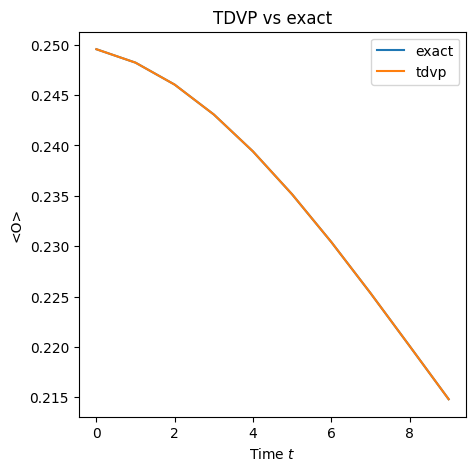

In [349]:
import matplotlib.pyplot as plt

fig1, axs1 = plt.subplots(1, 1, sharex=True, figsize=(5, 5))

# First plot
axs1.plot(exact_results, label='exact')
axs1.plot(tdvp_results, label='tdvp')

axs1.set_xlabel("Time $t$")
axs1.set_ylabel("<O>")
axs1.set_title("TDVP vs exact")

# Add a legend to distinguish between the two plots
axs1.legend()

plt.show()